In [ ]:
%pip install --user jetnet tables==3.8.0

In [1]:
import jetnet

im_size = 16
jet_r = 0.8
max_jets = 50000

# download the validation data (400k jets, which is plenty for our purposes)
# full dataset is available here: https://doi.org/10.5281/zenodo.2603255
data = jetnet.datasets.TopTagging(
    jet_type="all",
    particle_features=["E", "px", "py", "pz"],
    jet_features=["type"],
    split="valid",
    data_dir="data/",
    particle_transform=jetnet.utils.cartesian_to_relEtaPhiPt,
    download=True,
)

/Users/thea/.local/lib/python3.9/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


[██████████████████████████████████████████████████] 100%


In [4]:
import numpy as np

indices = np.random.permutation(np.arange(len(data)))[:max_jets]
# transform the data
transformed_particle_data = data.particle_transform(data.particle_data[indices])
# split qcd background and top quark signal
qcd_data = transformed_particle_data[data.jet_data[indices][:, 0] == 0]
top_data = transformed_particle_data[data.jet_data[indices][:, 0] == 1]
from sklearn.model_selection import train_test_split

qcd_train, qcd_test = train_test_split(qcd_data, test_size=0.2, random_state=42)
top_train, top_test = train_test_split(top_data, test_size=0.2, random_state=42)

In [5]:
import numpy as np

#  convert full dataset
qcd_train_images = np.expand_dims(jetnet.utils.to_image(qcd_train, im_size=im_size, maxR=jet_r), axis=-1)
qcd_test_images = np.expand_dims(jetnet.utils.to_image(qcd_test, im_size=im_size, maxR=jet_r), axis=-1)
top_test_images = np.expand_dims(jetnet.utils.to_image(top_test, im_size=im_size, maxR=jet_r), axis=-1)

# rescale so sum is 1 (it should be close already)
qcd_train_images = qcd_train_images / np.sum(qcd_train_images.reshape(-1, 1, 1, 1, im_size * im_size), axis=-1)
qcd_test_images = qcd_test_images / np.sum(qcd_test_images.reshape(-1, 1, 1, 1, im_size * im_size), axis=-1)
top_test_images = top_test_images / np.sum(top_test_images.reshape(-1, 1, 1, 1, im_size * im_size), axis=-1)

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


def plot_jet_images(images, titles, filename="jet_image.pdf"):

    n_images = len(images)
    plt.figure(figsize=(5 * n_images, 5))

    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, n_images, i + 1)
        plt.title(title)
        plt.imshow(image, origin="lower", norm=LogNorm(vmin=1e-3, vmax=1))
        cbar = plt.colorbar()
        plt.xlabel(r"$\Delta\eta$ cell", fontsize=15)
        plt.ylabel(r"$\Delta\phi$ cell", fontsize=15)
        cbar.set_label(r"$p_T/p_T^{jet}$", fontsize=15)

    plt.tight_layout()
    plt.savefig(filename)

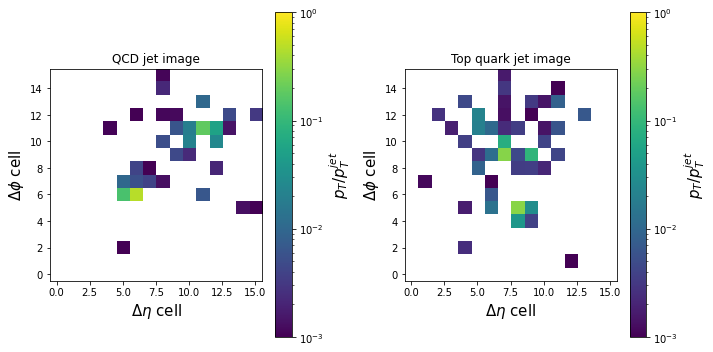

In [8]:
plot_jet_images([qcd_test_images[0], top_test_images[0]], ["QCD jet image", "Top quark jet image"])

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense,
    Input,
    Conv2D,
    Conv2DTranspose,
    Reshape,
    Flatten,
    Softmax,
)

x_in = Input(shape=(im_size, im_size, 1))
x = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation="relu", padding="same")(x_in)
x = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation="relu", padding="same")(x)
x = Flatten()(x)

x_enc = Dense(2, name="bottleneck")(x)

x = Dense(int(im_size * im_size / 16) * 128, activation="relu")(x_enc)
x = Reshape((int(im_size / 4), int(im_size / 4), 128))(x)
x = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), activation="relu", padding="same")(x)
x = Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), activation="linear", padding="same")(x)
x_out = Softmax(name="softmax", axis=[-2, -3])(x)
model = Model(inputs=x_in, outputs=x_out, name="autoencoder")

model.compile(loss="mse", optimizer="adam")
model.summary()

# save the encoder-only model for easy access to latent space
encoder = Model(inputs=x_in, outputs=x_enc, name="encoder")

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 128)         1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 bottleneck (Dense)          (None, 2)                 4098      
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         

2025-06-04 10:09:43.109224: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
history = model.fit(
    qcd_train_images,
    qcd_train_images,
    batch_size=32,
    epochs=10,
    verbose=0,
    validation_data=(qcd_test_images, qcd_test_images),
)

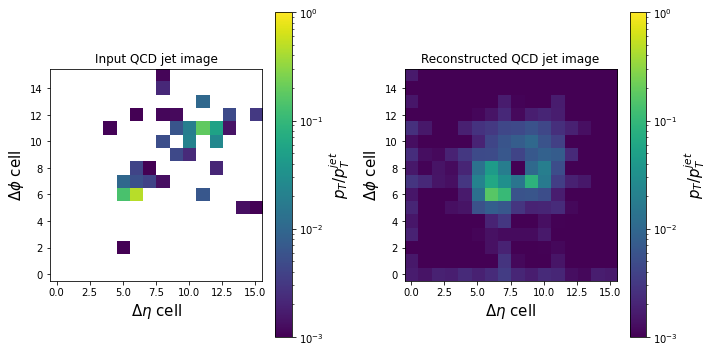

In [11]:
qcd_reco_image = model.predict(qcd_test_images[0:1], verbose=0).reshape(im_size, im_size)
plot_jet_images([qcd_test_images[0], qcd_reco_image], ["Input QCD jet image", "Reconstructed QCD jet image"])

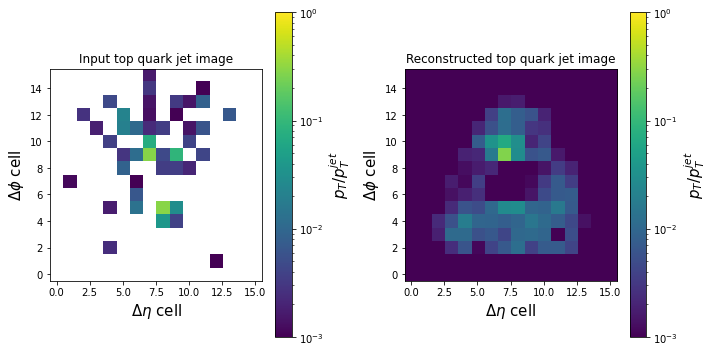

In [12]:
top_reco_image = model.predict(top_test_images[0:1], verbose=0).reshape(im_size, im_size)
plot_jet_images([top_test_images[0], top_reco_image], ["Input top quark jet image", "Reconstructed top quark jet image"])

In [13]:
qcd_reco_images = model.predict(qcd_test_images, verbose=0)
top_reco_images = model.predict(top_test_images, verbose=0)

In [14]:
diff_qcd = np.power((qcd_reco_images - qcd_test_images), 2)
loss_qcd = np.mean(diff_qcd.reshape(-1, im_size * im_size), axis=-1)

diff_top = np.power((top_reco_images - top_test_images), 2)
loss_top = np.mean(diff_top.reshape(-1, im_size * im_size), axis=-1)

loss_all = np.concatenate([loss_qcd, loss_top])

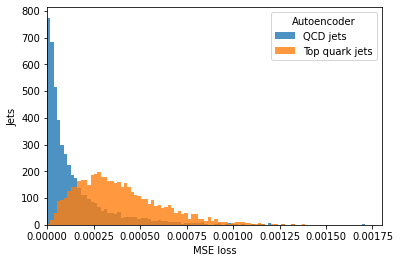

In [15]:
plt.figure()
bins = np.arange(0, np.max(loss_all), np.max(loss_all) / 100)
plt.hist(loss_qcd, label="QCD jets", bins=bins, alpha=0.8)
plt.hist(loss_top, label="Top quark jets", bins=bins, alpha=0.8)
plt.legend(title="Autoencoder")
plt.xlabel("MSE loss")
plt.ylabel("Jets")
plt.xlim(0, np.max(loss_all))
plt.show()

# Exercises

- Plot the ROC curve for the MSE loss of the autoencoder on the merged testing sample of QCD and top quark jets, assuming a label of 1 for top quark jets and a label of 0 for QCD jets. Report the AUC.

- Perform a PCA on only the QCD training images using sklearn.decomposition.PCA with 2 components. Note you will have to reshape the image tensors so that they are 2D instead of 4D (as required by the autoencoder), e.g. qcd_test_images.reshape(-1, im_size * im_size)). Plot the distribution of the reconstruction losses for top quark jets and QCD jets separately. Hint: review https://rittikghosh.com/autoencoder.html.

- Plot the PCA ROC curve similar to part 1. Report the AUC.

- Plot the 2D latent space for the QCD and top quark test images for both the autoencoder and the PCA.

- Turn the AE into a VAE. Hints:
